# <a id='toc1_'></a>[Projet 4, Partie 2 - Construisez un modèle de scoring](#toc0_)

**Table of contents**<a id='toc0_'></a>    
- [Projet 4, Partie 2 - Construisez un modèle de scoring](#toc1_)    
  - [Train](#toc1_1_)    
  - [Test](#toc1_2_)    
    - [Resultat LDA](#toc1_2_1_)    
    - [Resultat LGM](#toc1_2_2_)    
    - [Resultat NB](#toc1_2_3_)    
- [Optimisation des hyperparametres](#toc2_)    
  - [Optuna](#toc2_1_)    
- [Explication du modèle avec SHAP](#toc3_)    
  - [SHAP](#toc3_1_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

Comme nous l'avons vu dans la partie 1 (voir notebook précedant) notre choix de modèle c'est porte sur les modèles ayant les meilleures metriques a savoir: 

- Linear Discriminant Analysis (LDA)
- LightGBM (LGB)
- Naive Bayes (NB)

Pourquoi ? 

- LDA a les meilleures performance global (AUC, F1, Kappa, MCC)
- LGB a la meilleure precision et une des meilleure Accuracy
- NB a le meilleures recall


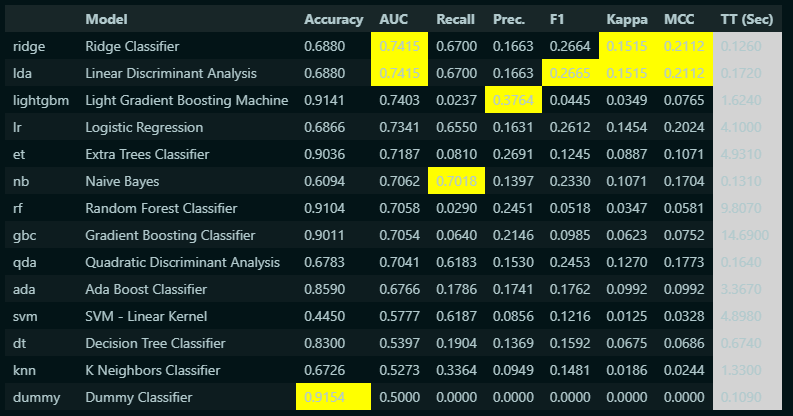

In [15]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
import numpy as np
from sklearn.naive_bayes import MultinomialNB, GaussianNB  
from lightgbm import LGBMClassifier 
import matplotlib.pyplot as plt
import seaborn as sns
# import numpy as np
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from imblearn.over_sampling import SMOTE 
import optuna
import logging
from lightgbm import LGBMClassifier
from sklearn.model_selection import cross_val_score

In [16]:
df_origin = pd.read_csv('../data/application_train.csv')
df = df_origin.copy()

In [17]:
class scoringCredit:
    def __init__(self, data , preprocessing_type: str):
        self.data = data
        self.preprocessing_type = preprocessing_type
        self.feature_importance_columns = None
        self.columns_without_context = [
            'SK_ID_CURR',
            'NAME_CONTRACT_TYPE',
            'NAME_TYPE_SUITE',
            'NAME_INCOME_TYPE',
            'NAME_EDUCATION_TYPE',
            'NAME_FAMILY_STATUS',
            'NAME_HOUSING_TYPE',
            'DAYS_ID_PUBLISH',
            'FLAG_EMP_PHONE',
            'FLAG_WORK_PHONE',
            'FLAG_PHONE',
            'FLAG_EMAIL',
            'DAYS_LAST_PHONE_CHANGE',
            'WEEKDAY_APPR_PROCESS_START'
        ]
        
    
    def handleMissingValues(self):
        try:
            # Calcul des valeurs manquantes par columns en %
            missing_percent_cols = (self.data.isna().sum() / len(self.data)) * 100

            # Crée une liste des colonnes ayant plus de 50% de valeurs manquantes
            drop_cols = missing_percent_cols[missing_percent_cols > 40]

            #  supressino des colonnes dans le dataframe
            self.data = self.data.drop(list(drop_cols.index), axis=1)

            # Recuperer toutes les colonnes qui ont encore des valeurs manquantes

            #Imputation avec knn imputer


            self.data = self.data.dropna()

            return self.data

        except Exception as error:
            raise error

        return f'Sucessfuly Delete: {list(drop_cols.index)}'


    def handleCategoricalsData(self):
        try:
            # Features Binaires
            binary_features = ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']

            # Traitement de CODE_GENDER pour supprimer xna
            if 'CODE_GENDER' in self.data.columns:
                self.data['CODE_GENDER'] = self.data['CODE_GENDER'].replace('XNA', pd.NA)

            # Convertir les variables binaires avec get_dummies
            self.data[binary_features] = pd.get_dummies(self.data[binary_features], drop_first=True).astype(int)

            # Features pour target encoding
            target_encoding_features = ['ORGANIZATION_TYPE', 'OCCUPATION_TYPE']
            for feature in target_encoding_features:
                if feature in self.data.columns:
                    target_mean = self.data.groupby(feature)['TARGET'].mean()
                    self.data[feature] = self.data[feature].map(target_mean)

            return self.data

        except Exception as error:
            raise error

        
    def featuresOptimisation(self):
        try:
            # Étape 1 : Colonnes FLAG
            flag_columns = self.data.filter(like='FLAG').columns
            self.data['FLAGS'] = self.data[flag_columns].sum(axis=1)
            self.data.drop(columns=flag_columns, inplace=True)

            # Étape 2 : Colonnes REGION
            region_columns = self.data.filter(like='REGION').columns.tolist()
            additional_region_columns = ['REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY']
            region_columns = [col for col in additional_region_columns if col in self.data.columns] + region_columns
            if region_columns: 
                self.data['REGION_SCORE'] = self.data[region_columns].sum(axis=1)
                self.data.drop(columns=region_columns, inplace=True)

            # Étape 3 : Calcul des ratios pour les colonnes AMT
            self.data['INCOME_CREDIT_RATIO'] = self.data['AMT_INCOME_TOTAL'] / self.data['AMT_CREDIT']
            self.data['ANNUITY_CREDIT_RATIO'] = self.data['AMT_ANNUITY'] / self.data['AMT_CREDIT']
            self.data['CREDIT_POSSESSION_RATIO'] = self.data['AMT_CREDIT'] / self.data['AMT_GOODS_PRICE']
            self.data['INCOME_ANNUITY_RATIO'] = self.data['AMT_INCOME_TOTAL'] / self.data['AMT_ANNUITY']

            # Étape 4 : PCA sur les colonnes AMT
            amt_columns = ['AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE']
            amt_columns = [col for col in amt_columns if col in self.data.columns]
            self.data.dropna(subset=amt_columns, inplace=True)

            if amt_columns: 
                scaler = StandardScaler()
                pca = PCA(n_components=1)
                self.data['AMT_PCA'] = pca.fit_transform(scaler.fit_transform(self.data[amt_columns]))

            # Étape 5 : Traitement spécifique pour TRAIN
            if getattr(self, 'preprocessing_type', None) == 'TRAIN':

                # Supprimer les valeurs manquantes restantes
                self.data = self.data.dropna()

                X = self.data.drop('TARGET', axis=1)
                y = self.data['TARGET']

                # Appliquer SMOTE pour équilibrer les classes
                smote = SMOTE(random_state=42)
                X_resampled, y_resampled = smote.fit_resample(X, y)

                # Features selection avec SelectKBest
                num_selector = SelectKBest(score_func=f_classif, k='all').fit(X_resampled, y_resampled)

                # Scores des features
                scores = num_selector.scores_

                feature_scores = pd.DataFrame({
                    'Feature': np.array(X_resampled.columns),
                    'Score': scores
                })

                # Trier par importance
                feature_scores = feature_scores.sort_values(by='Score', ascending=False)

                # Retourner les 15 features les plus importantes
                self.feature_importance_columns = feature_scores[:15].Feature

                return X_resampled[self.feature_importance_columns], y_resampled
            else:
                y = self.data['TARGET']

            return self.data[self.feature_importance_columns], y

        except Exception as error:
            raise error

    

    def preprocessing(self):
        try:
            # Étape 1 : Supprimer les colonnes sans contexte métier
            self.data = self.data.drop(self.columns_without_context, axis=1, errors='ignore')

            # Étape 2 : Gestion des valeurs manquantes
            self.data = self.handleMissingValues()

            # Étape 3 : Gestion des données qualitatives
            self.data = self.handleCategoricalsData()

            # Étape 4 : Feature engineering & selection
            X, y = self.featuresOptimisation()

            return X, y

        except Exception as error:
            # Ajouter plus de contexte à l'erreur
            raise RuntimeError(f"Error in preprocessing step: {error}") from error


    

    def compute_class_weights(self, y_train, imbalance_factor=10):
        """
        Calcule les poids de classe pour que la classe minoritaire soit pondérée 10 fois plus.
        Retourne un dictionnaire utilisable dans les modèles acceptant class_weight.
        """
        class_counts = np.bincount(y_train)
        total_samples = len(y_train)
        # Calcul des poids pour chaque classe
        class_weights = {0: 1, 1: 1}  # Initialise avec des valeurs par défaut

        if len(class_counts) == 2:  # S'assure qu'il y a bien deux classes
            minority_class = np.argmin(class_counts)
            majority_class = np.argmax(class_counts)

            class_weights[majority_class] = 1
            class_weights[minority_class] = imbalance_factor

        return class_weights

    def train(self, model, X_train, y_train, imbalance_factor=10):
        try:
            # Calculer les poids de classe personnalisés
            class_weights = self.compute_class_weights(y_train, imbalance_factor)
            print(f"Class Weights: {class_weights}")

            # Modèles supportant class_weight directement
            if hasattr(model, 'class_weight'):
                model.set_params(class_weight=class_weights)
                model.fit(X_train, y_train)

             # Pour LightGBM
            elif isinstance(model, LGBMClassifier):
                scale_pos_weight = class_weights[1] / class_weights[0]
                model.set_params(scale_pos_weight=scale_pos_weight)

                # Configurer LightGBM avec une fonction de validation personnalisée
                model.fit(
                    X_train,
                    y_train,
                    eval_set=[(X_valid, y_valid)] if X_valid is not None else None,
                    eval_metric=self.custom_metric,  # Ajout de la métrique personnalisée
                    early_stopping_rounds=10,
                    verbose=10,
                )

           
            # elif isinstance(model, LGBMClassifier):
            #     scale_pos_weight = class_weights[1] / class_weights[0]
            #     model.set_params(scale_pos_weight=scale_pos_weight)
            #     model.fit(X_train, y_train)

            # Pour Naive Bayes
            elif isinstance(model, GaussianNB):
                # Appliquer des priors basés sur les poids de classe
                total = sum(class_weights.values())
                priors = [class_weights[cls] / total for cls in sorted(class_weights.keys())]
                model.set_params(priors=priors)
                model.fit(X_train, y_train)

            elif isinstance(model, MultinomialNB):
                # MultinomialNB ne supporte pas les priors pondérés explicitement
                raise ValueError("MultinomialNB does not support class weighting")

            # Pour Linear Discriminant Analysis (LDA)
            elif isinstance(model, LinearDiscriminantAnalysis):
                # Utilisation de SMOTE car class_weight n'est pas supporté
                smote = SMOTE(random_state=42)
                X_train_res, y_train_res = smote.fit_resample(X_train, y_train)
                model.fit(X_train_res, y_train_res)

            else:
                raise ValueError("Unsupported model for custom class weighting.")

            return model

        except Exception as error:
            raise RuntimeError(f"Error in training with custom weights: {error}") from error

In [18]:
from sklearn.metrics import (
    accuracy_score, f1_score, recall_score, precision_score, 
    cohen_kappa_score, matthews_corrcoef, roc_auc_score, roc_curve, 
    precision_recall_curve, confusion_matrix, auc
)

def displayMetrics(model, X_test, y_test):
    # Prédictions
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else y_pred

    # Calcul des métriques
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    kappa = cohen_kappa_score(y_test, y_pred)
    mcc = matthews_corrcoef(y_test, y_pred)

    # Vérifier si c'est un problème de classification binaire pour l'AUC et PR AUC
    is_binary = len(np.unique(y_test)) == 2
    auc_score = roc_auc_score(y_test, y_proba) if is_binary else None
    
    # Precision-Recall AUC
    if is_binary:
        precision_vals, recall_vals, _ = precision_recall_curve(y_test, y_proba)
        pr_auc = auc(recall_vals, precision_vals)
    else:
        pr_auc = None

    # Affichage des métriques
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Cohen's Kappa: {kappa:.4f}")
    print(f"MCC: {mcc:.4f}")
    if is_binary:
        print(f"ROC AUC: {auc_score:.4f}")
        print(f"PR AUC: {pr_auc:.4f}")
    else:
        print("AUC: Non applicable pour une classification multiclass")

    # Création des subplots
    n_plots = 3 if is_binary else 1
    fig, axes = plt.subplots(1, n_plots, figsize=(20, 6))
    
    # Matrice de confusion
    cm = confusion_matrix(y_test, y_pred)
    classes = np.unique(y_test)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=axes[0] if is_binary else axes, 
                xticklabels=classes, yticklabels=classes)
    axes[0].set_title("Matrice de confusion", fontsize=16)
    axes[0].set_xlabel("Prédictions", fontsize=12)
    axes[0].set_ylabel("Véritables classes", fontsize=12)
    
    # Courbe ROC pour les problèmes binaires
    if is_binary:
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        axes[1].plot(fpr, tpr, label=f"ROC Curve (AUC = {auc_score:.2f})", color='blue')
        axes[1].plot([0, 1], [0, 1], linestyle='--', color='gray', label="Random Classifier")
        axes[1].set_xlim([0.0, 1.0])
        axes[1].set_ylim([0.0, 1.0])
        axes[1].set_xlabel("False Positive Rate (FPR)")
        axes[1].set_ylabel("True Positive Rate (TPR)")
        axes[1].set_title("ROC Curve", fontsize=16)
        axes[1].legend(loc="lower right")
        
        # Courbe Precision-Recall
        axes[2].plot(recall_vals, precision_vals, label=f"PR Curve (AUC = {pr_auc:.2f})", color='green')
        axes[2].set_xlim([0.0, 1.0])
        axes[2].set_ylim([0.0, 1.0])
        axes[2].set_xlabel("Recall")
        axes[2].set_ylabel("Precision")
        axes[2].set_title("PR-AUC", fontsize=16)
        axes[2].legend(loc="lower left")
    
    plt.tight_layout()
    plt.show()

    return y_pred


## <a id='toc1_1_'></a>[Train](#toc0_)

In [19]:
from sklearn.model_selection import train_test_split

X = df.drop('TARGET', axis=1)
Y = df.TARGET

# Effectuer la division
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Concaténer X_train et y_train
df_train = pd.concat([X_train, y_train], axis=1)
df_test = pd.concat([X_test, y_test], axis=1)

print(X_test.shape, y_test.shape)
print(X_train.shape, y_train.shape)

(61503, 121) (61503,)
(246008, 121) (246008,)


In [20]:
# initialiser la classe
SC = scoringCredit(df_train, 'TRAIN')

# Appliquer le preprocessing au df
X_train,y_train = SC.preprocessing()

In [21]:
# Entrainement du modele LDA
LDA = SC.train(LinearDiscriminantAnalysis(), X_train, y_train)

Class Weights: {0: 10, 1: 1}


In [22]:
# Entrainement du modele LGM
LGM = SC.train(LGBMClassifier(), X_train, y_train)

Class Weights: {0: 10, 1: 1}
[LightGBM] [Info] Number of positive: 123269, number of negative: 123269
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018548 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2849
[LightGBM] [Info] Number of data points in the train set: 246538, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.090909 -> initscore=-2.302585
[LightGBM] [Info] Start training from score -2.302585


In [25]:
# Modèle LightGBM
model = LGBMClassifier(random_state=42)

# Entraînement avec une métrique personnalisée
LGM2 = SC.train(model, X_train, y_train)

Class Weights: {0: 10, 1: 1}
[LightGBM] [Info] Number of positive: 123269, number of negative: 123269
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017821 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2848
[LightGBM] [Info] Number of data points in the train set: 246538, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.090909 -> initscore=-2.302585
[LightGBM] [Info] Start training from score -2.302585


In [26]:
NB = SC.train(GaussianNB(), X_train, y_train)

Class Weights: {0: 10, 1: 1}


## <a id='toc1_2_'></a>[Test](#toc0_)

In [27]:
# Definir les nouveaux parametre de classe pour les données de test
SC.preprocessing_type = 'TEST'
SC.data = df_test
print(SC.preprocessing_type, len(SC.data.columns), SC.data.shape)

# Appliquer le preprocessing sur les données de test
X_test,y_test = SC.preprocessing()

# Afficher la taille de X et y
X_test.shape, y_test.shape

TEST 122 (61503, 122)


((33683, 15), (33683,))

### <a id='toc1_2_1_'></a>[Resultat LDA](#toc0_)

Accuracy: 0.6982
F1 Score: 0.2533
Recall: 0.6007
Precision: 0.1605
Cohen's Kappa: 0.1373
MCC: 0.1845
ROC AUC: 0.7109
PR AUC: 0.2067


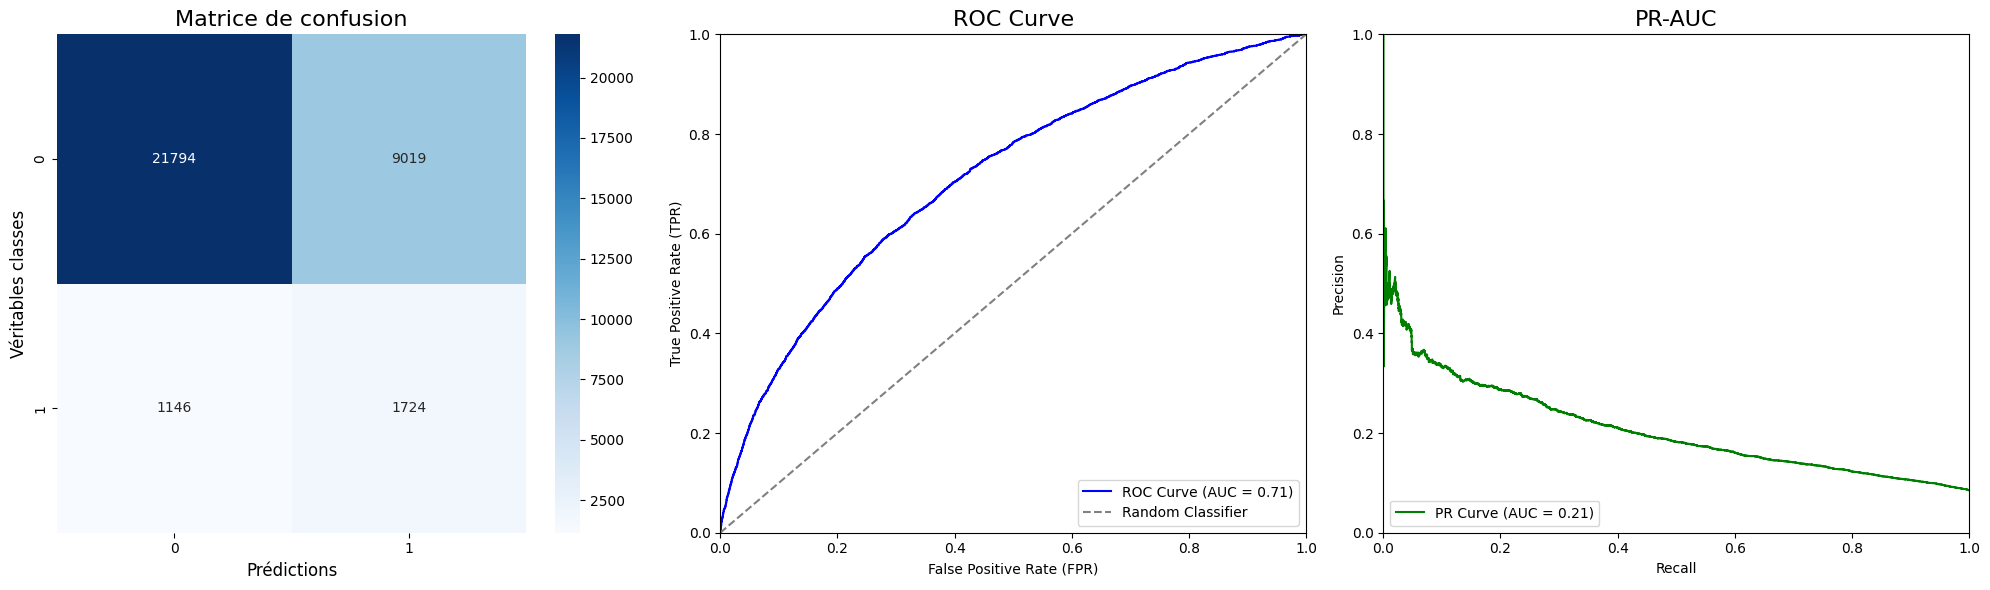

In [28]:
y_pred_lda = displayMetrics(LDA, X_test, y_test)

### <a id='toc1_2_2_'></a>[Resultat LGM](#toc0_)

Accuracy: 0.4263
F1 Score: 0.1824
Recall: 0.7509
Precision: 0.1038
Cohen's Kappa: 0.0384
MCC: 0.0844
ROC AUC: 0.6203
PR AUC: 0.1251


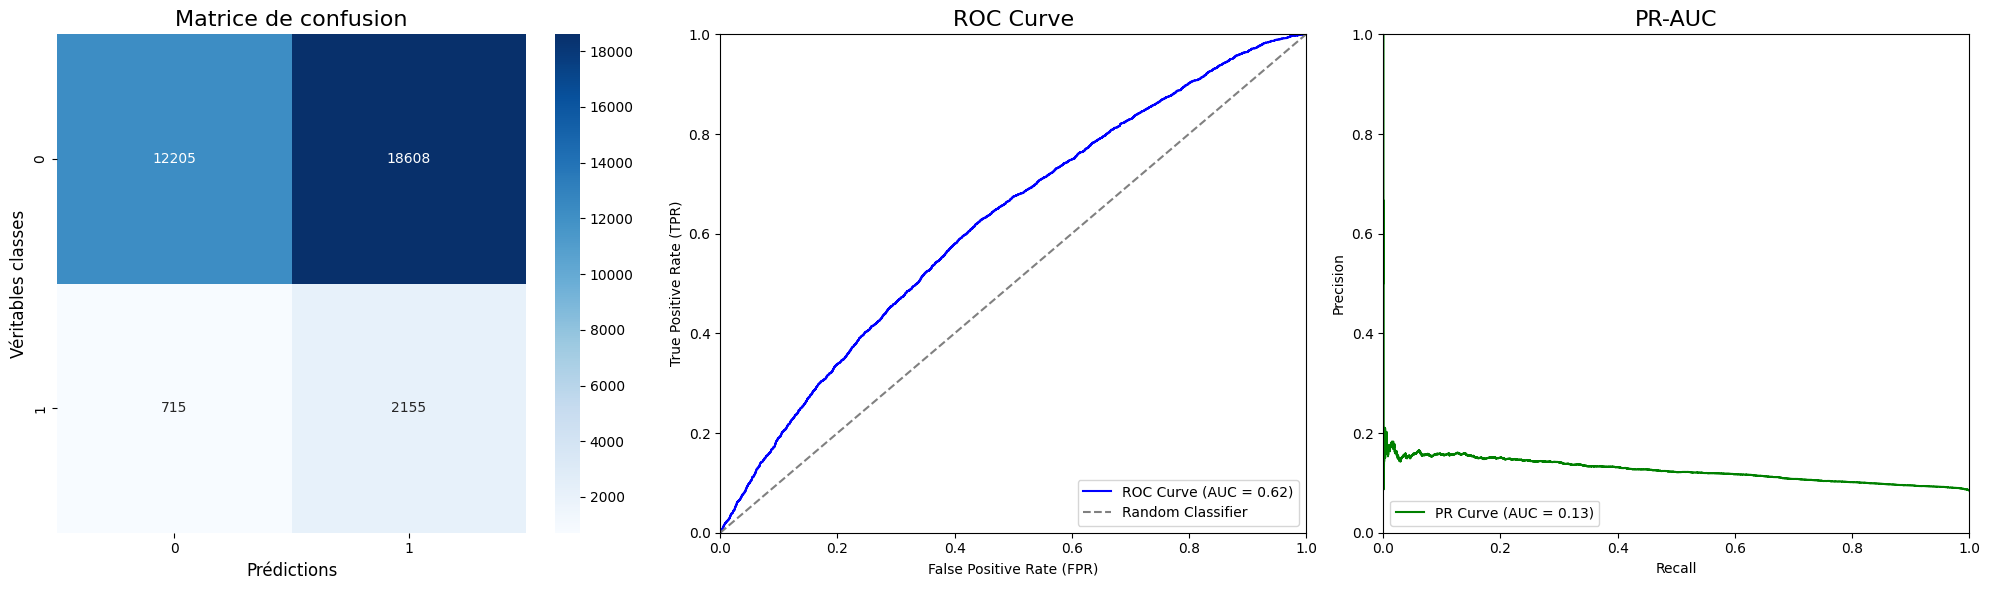

In [29]:
y_pred_lgm = displayMetrics(LGM, X_test, y_test)

Accuracy: 0.4090
F1 Score: 0.1799
Recall: 0.7606
Precision: 0.1020
Cohen's Kappa: 0.0349
MCC: 0.0794
ROC AUC: 0.6195
PR AUC: 0.1258


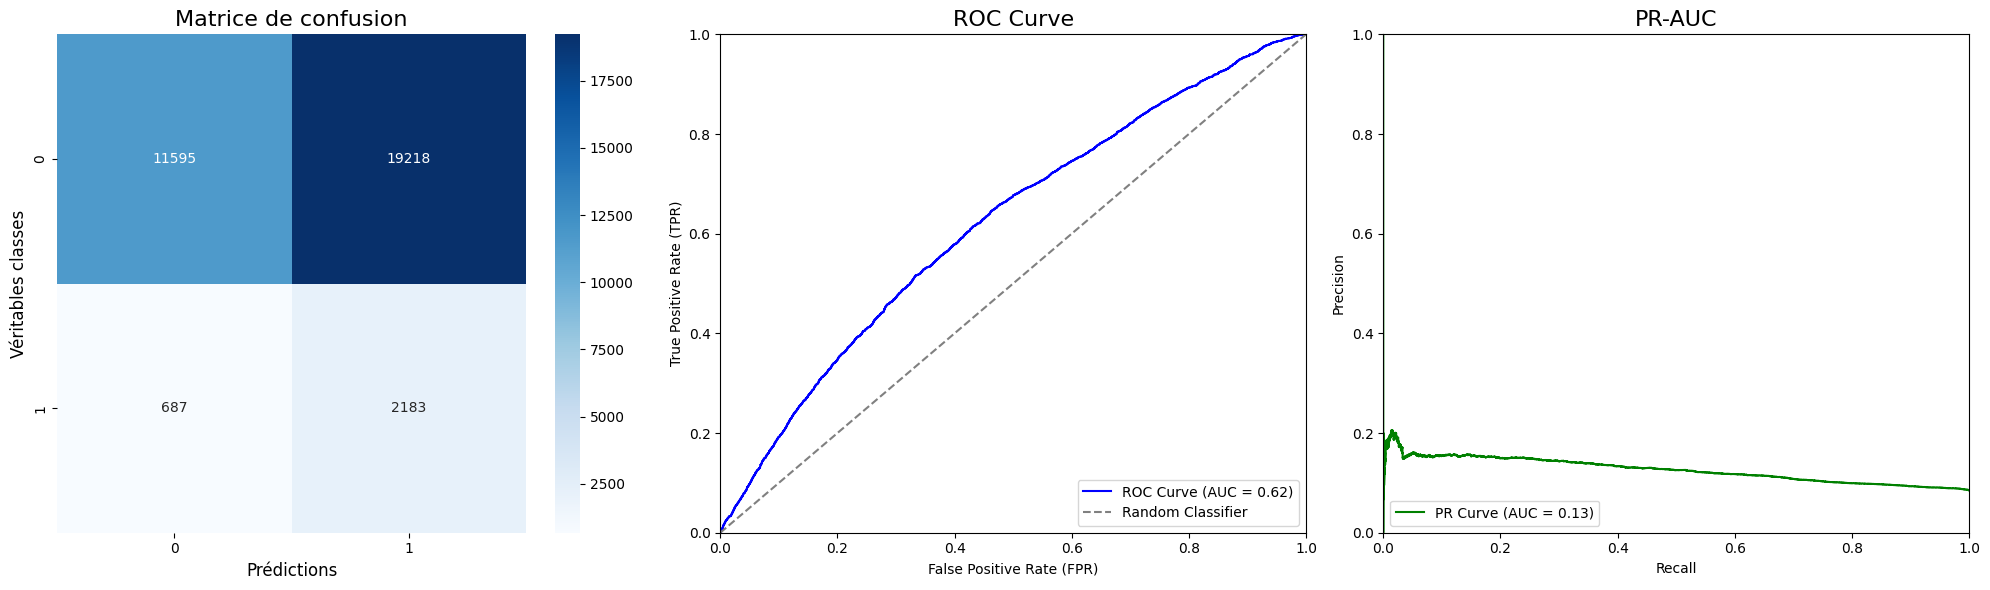

In [30]:
y_pred_lgm = displayMetrics(LGM2, X_test, y_test)

### <a id='toc1_2_3_'></a>[Resultat NB](#toc0_)

c:\Users\vuill\OneDrive\Documents\GitHub\OpenClassrooms\Projet 4 - Construisez un modèle de scoring\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Accuracy: 0.9148
F1 Score: 0.0000
Recall: 0.0000
Precision: 0.0000
Cohen's Kappa: 0.0000
MCC: 0.0000
ROC AUC: 0.6085
PR AUC: 0.1169


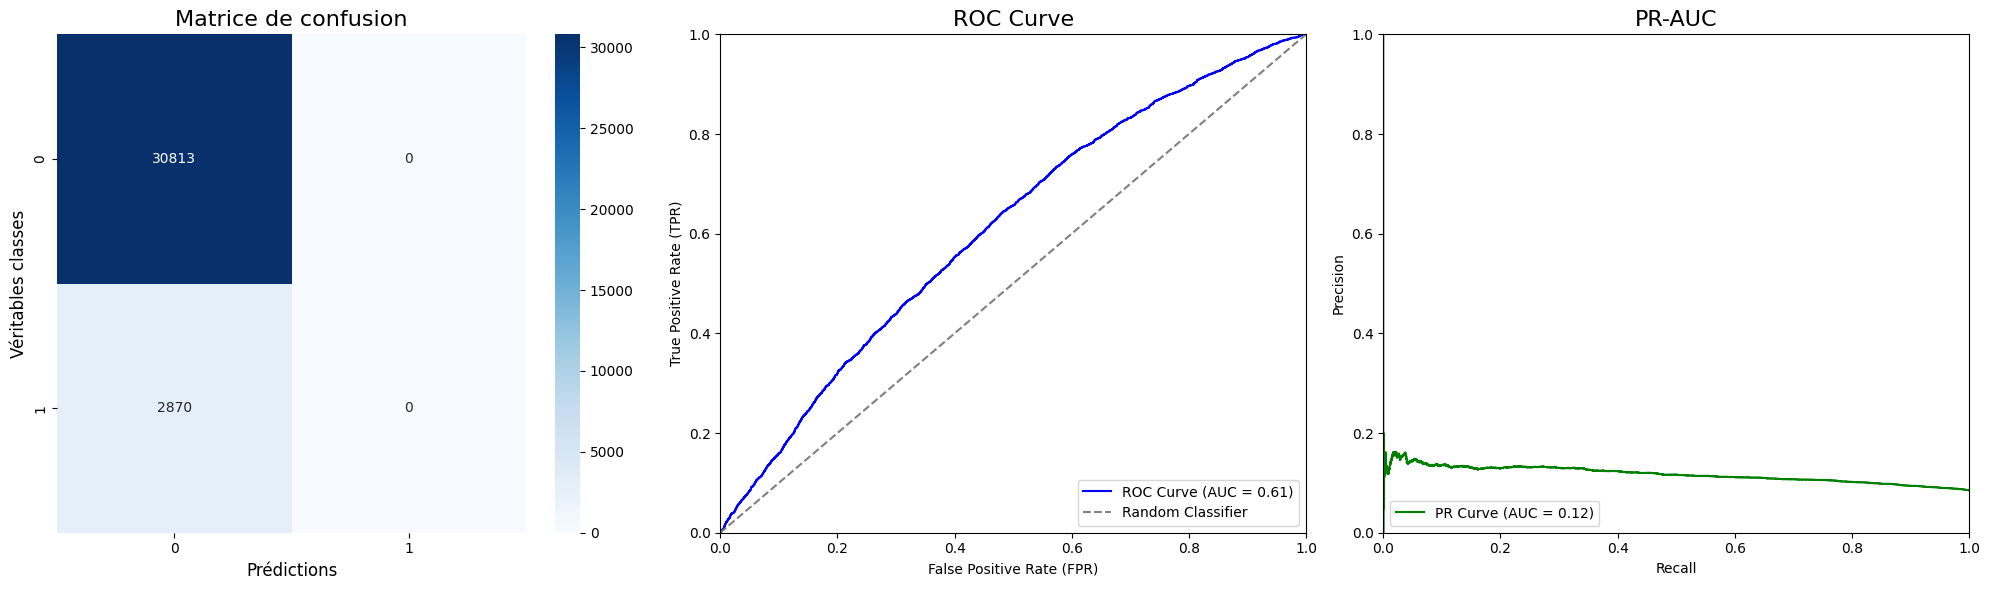

In [31]:
y_pred_nb = displayMetrics(NB, X_test, y_test)

Le modèle qui obtient les meilleures resultat est donc pour le moment LGM qui obtient les meilleures metrics, cependant ce n'est pas un modèle qui est très optimal et performant, nous allons donc passer a la deuxieme etape, l'optimisation des hyperparamètres pour voir si nous pouvons avoir une amelioration significative de notre modèle 

# <a id='toc2_'></a>[Optimisation des hyperparametres](#toc0_)

## <a id='toc2_1_'></a>[Optuna](#toc0_)

In [32]:
# Fonction objective à optimiser
def objective(trial):
    param = {
        'num_leaves': trial.suggest_int('num_leaves', 20, 100),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'min_child_samples': trial.suggest_int('min_child_samples', 10, 50),
        'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0)
    }

    model = LGBMClassifier(**param)
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='f1')
    return scores.mean()

# Configurer le logger d'Optuna pour limiter les logs
optuna.logging.set_verbosity(optuna.logging.WARNING)  # Limiter l'affichage des logs à WARNING

# Créer l'étude (study)
study = optuna.create_study(direction='maximize')

# Optimisation
study.optimize(objective, n_trials=20)

# Afficher les meilleurs paramètres
print("Best parameters:", study.best_params)


C:\Users\vuill\AppData\Local\Temp\ipykernel_2888\1372984609.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
C:\Users\vuill\AppData\Local\Temp\ipykernel_2888\1372984609.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
C:\Users\vuill\AppData\Local\Temp\ipykernel_2888\1372984609.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0)


[LightGBM] [Info] Number of positive: 98615, number of negative: 98615
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012248 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2848
[LightGBM] [Info] Number of data points in the train set: 197230, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 98615, number of negative: 98615
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013437 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2848
[LightGBM] [Info] Number of data points in the train set: 197230, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 98615, number of negative: 98615
[LightGBM] [Info] Auto-choosing col-wise multi-th

C:\Users\vuill\AppData\Local\Temp\ipykernel_2888\1372984609.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
C:\Users\vuill\AppData\Local\Temp\ipykernel_2888\1372984609.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
C:\Users\vuill\AppData\Local\Temp\ipykernel_2888\1372984609.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0)


[LightGBM] [Info] Number of positive: 98615, number of negative: 98615
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014525 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2848
[LightGBM] [Info] Number of data points in the train set: 197230, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 98615, number of negative: 98615
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013741 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2848
[LightGBM] [Info] Number of data points in the train set: 197230, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 98615, number of negative: 98615
[LightGBM] [Info] Auto-choosing col-wise multi-th

C:\Users\vuill\AppData\Local\Temp\ipykernel_2888\1372984609.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
C:\Users\vuill\AppData\Local\Temp\ipykernel_2888\1372984609.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
C:\Users\vuill\AppData\Local\Temp\ipykernel_2888\1372984609.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0)


[LightGBM] [Info] Number of positive: 98615, number of negative: 98615
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014394 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2848
[LightGBM] [Info] Number of data points in the train set: 197230, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 98615, number of negative: 98615
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013089 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2848
[LightGBM] [Info] Number of data points in the train set: 197230, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 98615, number of negative: 98615
[LightGBM] [Info] Auto-choosing col-wise multi-th

C:\Users\vuill\AppData\Local\Temp\ipykernel_2888\1372984609.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
C:\Users\vuill\AppData\Local\Temp\ipykernel_2888\1372984609.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
C:\Users\vuill\AppData\Local\Temp\ipykernel_2888\1372984609.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0)


[LightGBM] [Info] Number of positive: 98615, number of negative: 98615
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006184 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2848
[LightGBM] [Info] Number of data points in the train set: 197230, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 98615, number of negative: 98615
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011351 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2848
[LightGBM] [Info] Number of data points in the train set: 197230, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 98615, number of n

C:\Users\vuill\AppData\Local\Temp\ipykernel_2888\1372984609.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
C:\Users\vuill\AppData\Local\Temp\ipykernel_2888\1372984609.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
C:\Users\vuill\AppData\Local\Temp\ipykernel_2888\1372984609.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0)


[LightGBM] [Info] Number of positive: 98615, number of negative: 98615
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016463 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2848
[LightGBM] [Info] Number of data points in the train set: 197230, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 98615, number of negative: 98615
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013333 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2848
[LightGBM] [Info] Number of data points in the train set: 197230, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 98615, number of negative: 98615
[LightGBM] [Info] Auto-choosing col-wise multi-th

C:\Users\vuill\AppData\Local\Temp\ipykernel_2888\1372984609.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
C:\Users\vuill\AppData\Local\Temp\ipykernel_2888\1372984609.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
C:\Users\vuill\AppData\Local\Temp\ipykernel_2888\1372984609.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0)


[LightGBM] [Info] Number of positive: 98615, number of negative: 98615
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013254 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2848
[LightGBM] [Info] Number of data points in the train set: 197230, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 98615, number of negative: 98615
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012656 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2848
[LightGBM] [Info] Number of data points in the train set: 197230, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 98615, number of negative: 98615
[LightGBM] [Info] Auto-choosing col-wise multi-th

C:\Users\vuill\AppData\Local\Temp\ipykernel_2888\1372984609.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
C:\Users\vuill\AppData\Local\Temp\ipykernel_2888\1372984609.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
C:\Users\vuill\AppData\Local\Temp\ipykernel_2888\1372984609.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0)


[LightGBM] [Info] Number of positive: 98615, number of negative: 98615
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014998 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2848
[LightGBM] [Info] Number of data points in the train set: 197230, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 98615, number of negative: 98615
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014385 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2848
[LightGBM] [Info] Number of data points in the train set: 197230, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 98615, number of negative: 98615
[LightGBM] [Info] Auto-choosing col-wise multi-th

C:\Users\vuill\AppData\Local\Temp\ipykernel_2888\1372984609.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
C:\Users\vuill\AppData\Local\Temp\ipykernel_2888\1372984609.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
C:\Users\vuill\AppData\Local\Temp\ipykernel_2888\1372984609.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0)


[LightGBM] [Info] Number of positive: 98615, number of negative: 98615
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014235 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2848
[LightGBM] [Info] Number of data points in the train set: 197230, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 98615, number of negative: 98615
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014389 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2848
[LightGBM] [Info] Number of data points in the train set: 197230, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 98615, number of negative: 98615
[LightGBM] [Info] Auto-choosing col-wise multi-th

C:\Users\vuill\AppData\Local\Temp\ipykernel_2888\1372984609.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
C:\Users\vuill\AppData\Local\Temp\ipykernel_2888\1372984609.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
C:\Users\vuill\AppData\Local\Temp\ipykernel_2888\1372984609.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0)


[LightGBM] [Info] Number of positive: 98615, number of negative: 98615
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012824 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2848
[LightGBM] [Info] Number of data points in the train set: 197230, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 98615, number of negative: 98615
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014319 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2848
[LightGBM] [Info] Number of data points in the train set: 197230, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 98615, number of negative: 98615
[LightGBM] [Info] Auto-choosing col-wise multi-th

C:\Users\vuill\AppData\Local\Temp\ipykernel_2888\1372984609.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
C:\Users\vuill\AppData\Local\Temp\ipykernel_2888\1372984609.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
C:\Users\vuill\AppData\Local\Temp\ipykernel_2888\1372984609.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0)


[LightGBM] [Info] Number of positive: 98615, number of negative: 98615
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013112 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2848
[LightGBM] [Info] Number of data points in the train set: 197230, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 98615, number of negative: 98615
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012820 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2848
[LightGBM] [Info] Number of data points in the train set: 197230, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 98615, number of negative: 98615
[LightGBM] [Info] Auto-choosing col-wise multi-th

C:\Users\vuill\AppData\Local\Temp\ipykernel_2888\1372984609.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
C:\Users\vuill\AppData\Local\Temp\ipykernel_2888\1372984609.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
C:\Users\vuill\AppData\Local\Temp\ipykernel_2888\1372984609.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0)


[LightGBM] [Info] Number of positive: 98615, number of negative: 98615
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012651 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2848
[LightGBM] [Info] Number of data points in the train set: 197230, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spl

C:\Users\vuill\AppData\Local\Temp\ipykernel_2888\1372984609.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
C:\Users\vuill\AppData\Local\Temp\ipykernel_2888\1372984609.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
C:\Users\vuill\AppData\Local\Temp\ipykernel_2888\1372984609.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0)


[LightGBM] [Info] Number of positive: 98615, number of negative: 98615
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013086 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2848
[LightGBM] [Info] Number of data points in the train set: 197230, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 98615, number of negative: 98615
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011161 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2848
[LightGBM] [Info] Number of data points in the train set: 197230, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 98615, number of negative: 98615
[LightGBM] [Info] Auto-choosing col-wise multi-th

[W 2025-01-07 22:25:05,192] Trial 11 failed with parameters: {'num_leaves': 66, 'learning_rate': 0.19078386511338002, 'n_estimators': 992, 'min_child_samples': 21, 'subsample': 0.8813303916007446, 'colsample_bytree': 0.7288799830665236} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "c:\Users\vuill\OneDrive\Documents\GitHub\OpenClassrooms\Projet 4 - Construisez un modèle de scoring\.venv\Lib\site-packages\optuna\study\_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\vuill\AppData\Local\Temp\ipykernel_2888\1372984609.py", line 13, in objective
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='f1')
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\vuill\OneDrive\Documents\GitHub\OpenClassrooms\Projet 4 - Construisez un modèle de scoring\.venv\Lib\site-packages\sklearn\utils\_param_validation.py", line 213, i

KeyboardInterrupt: 

In [15]:
# Entrainer le modèle avec les meilleurs params
lgb_optimized = SC.train(LGBMClassifier(**study.best_params), X_train=X_train, y_train=y_train) 

Class Weights: {0: 10, 1: 1}
[LightGBM] [Info] Number of positive: 123269, number of negative: 123269
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015982 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2849
[LightGBM] [Info] Number of data points in the train set: 246538, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.090909 -> initscore=-2.302585
[LightGBM] [Info] Start training from score -2.302585


Accuracy: 0.2504
F1 Score: 0.1719
Recall: 0.9129
Precision: 0.0949
Cohen's Kappa: 0.0207
MCC: 0.0738
ROC AUC: 0.6272
PR AUC: 0.1307


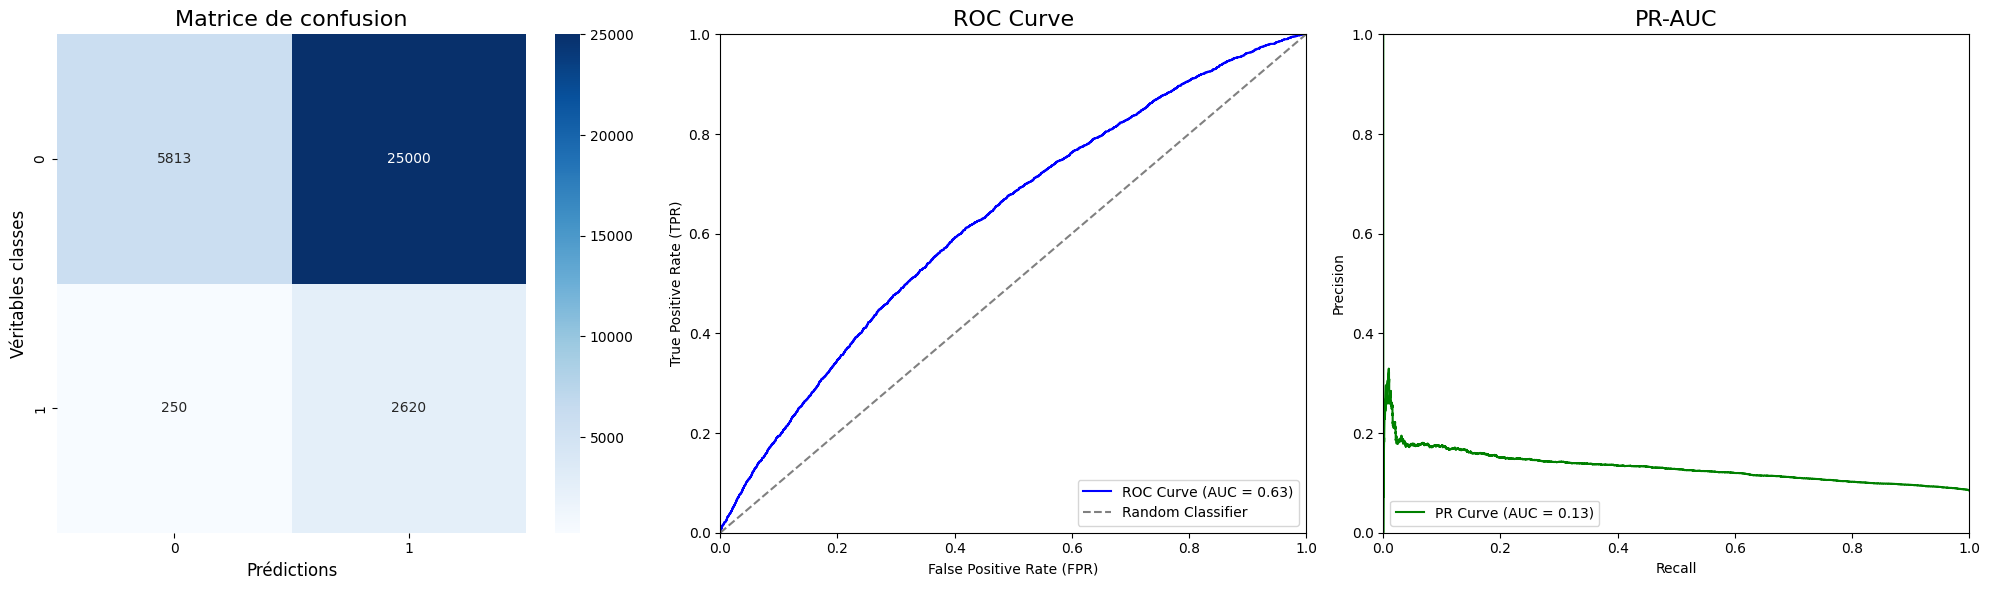

In [16]:
y_pred_lda = displayMetrics(lgb_optimized, X_test, y_test)

# <a id='toc3_'></a>[Explication du modèle avec SHAP](#toc0_)

https://shap.readthedocs.io/en/latest/example_notebooks/tabular_examples/tree_based_models/Census%20income%20classification%20with%20LightGBM.html

In [17]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split

import shap

# print the JS visualization code to the notebook
shap.initjs()

In [18]:
explainer = shap.TreeExplainer(lgb_optimized)


In [19]:
shap_values = explainer(X_train)

## Explication Globale

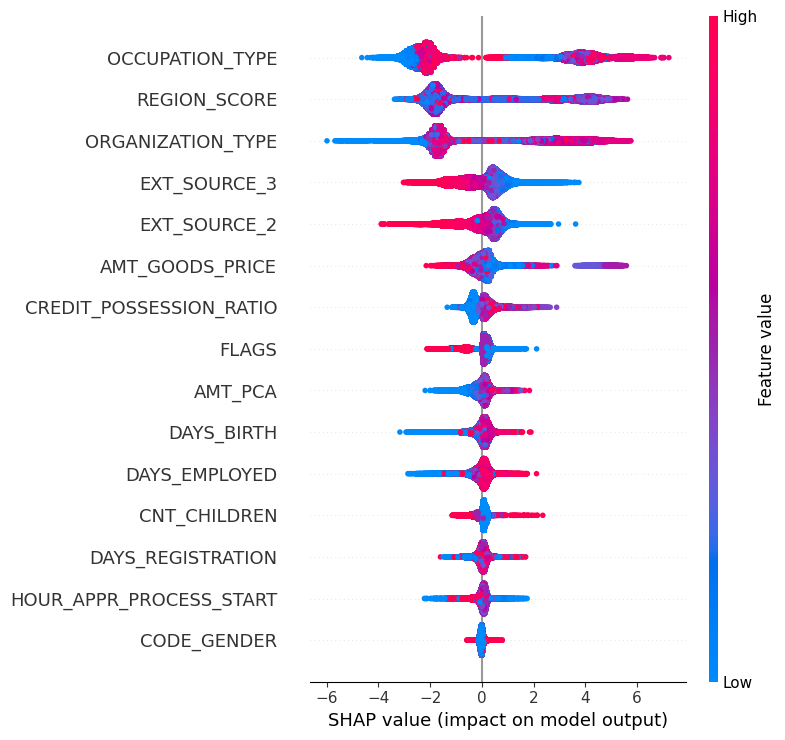

In [20]:
shap.summary_plot(shap_values, X_train)

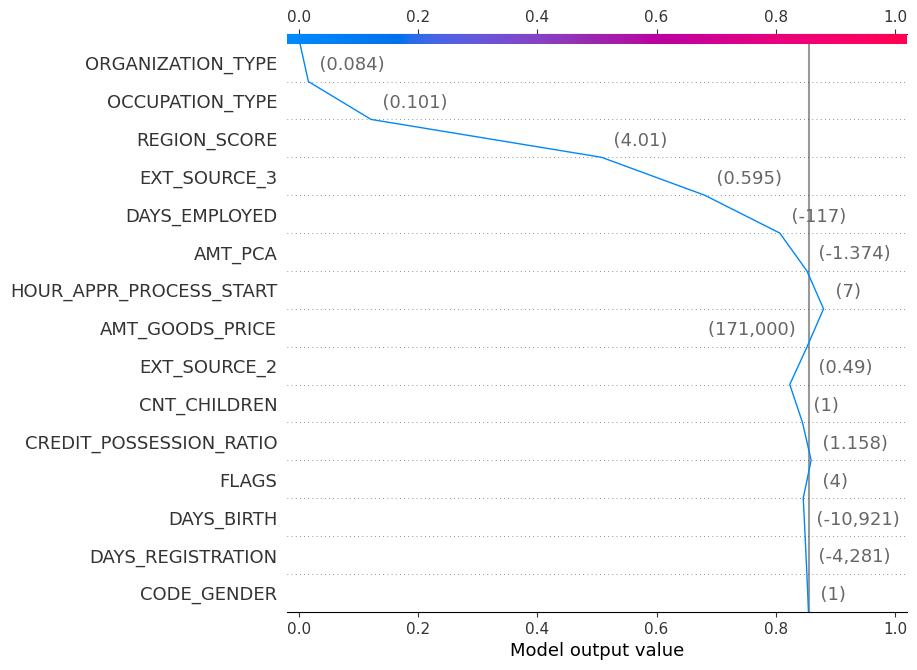

In [26]:
# Visualisation pour une observation spécifique
shap.decision_plot(
    base_value=shap_values[0].base_values,  # Valeur de base pour l'instance
    shap_values=shap_values[0].values,     # Valeurs SHAP pour l'instance
    features=X_train.iloc[0],             # Caractéristiques pour l'instance
    link="logit"
)

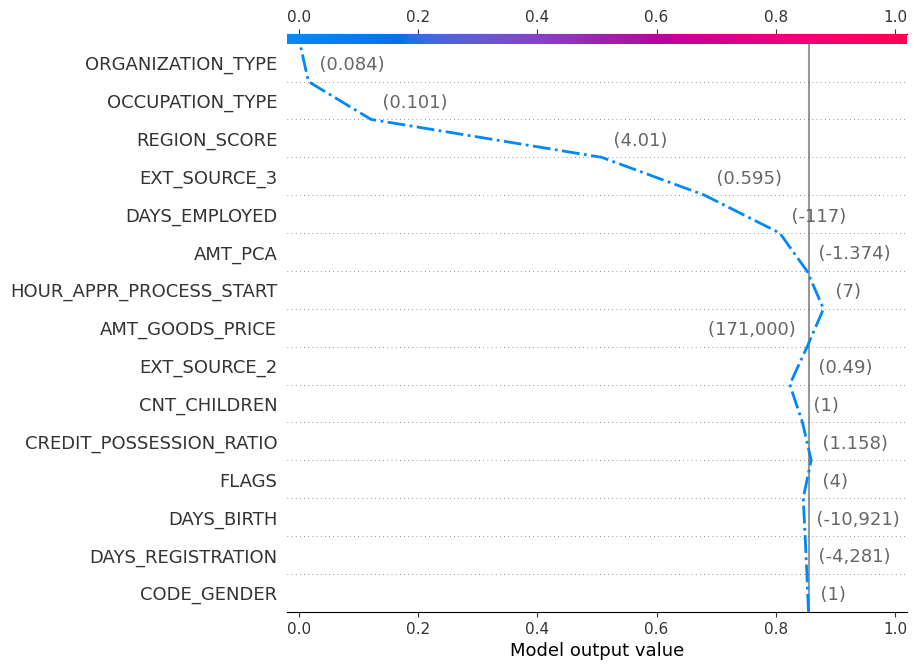

In [29]:
shap.decision_plot(
    base_value=shap_values[0].base_values,
    shap_values=shap_values[0].values,
    features=X_train.iloc[0],
    link="logit",
    highlight=0,  # Permet de mettre en valeur une caractéristique
    color_bar=True,  # Ajoute une barre de couleurs
    # feature_names=X_train.columns  # Si vous souhaitez personnaliser les noms
)


## Explication Locale

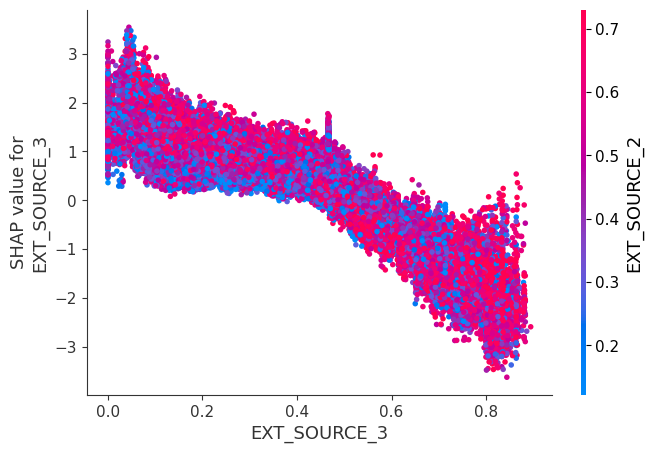

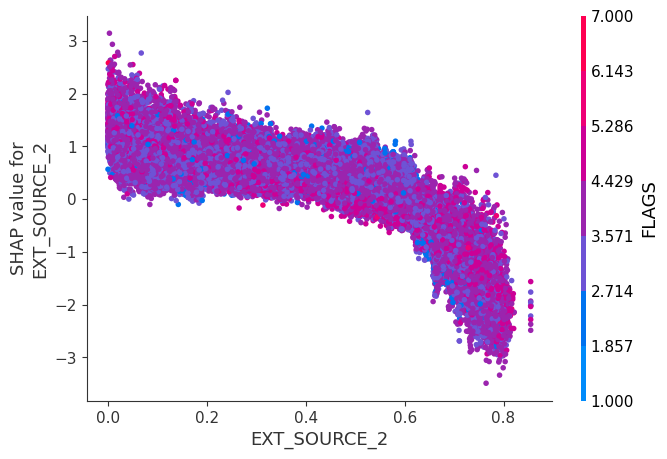

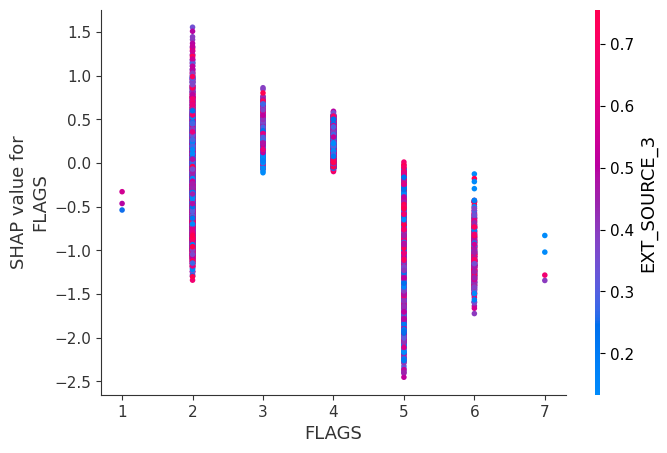

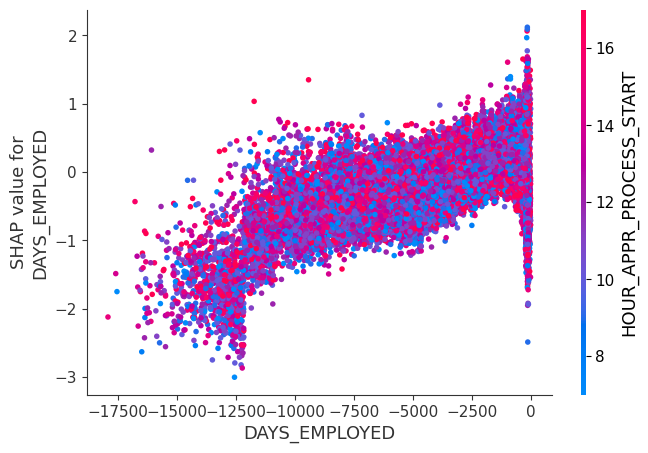

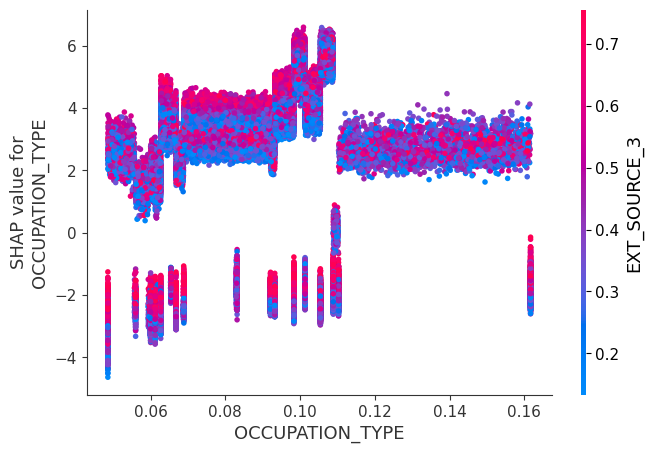

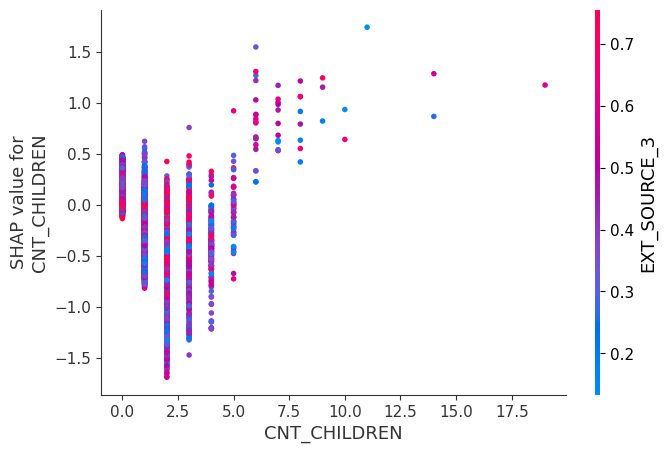

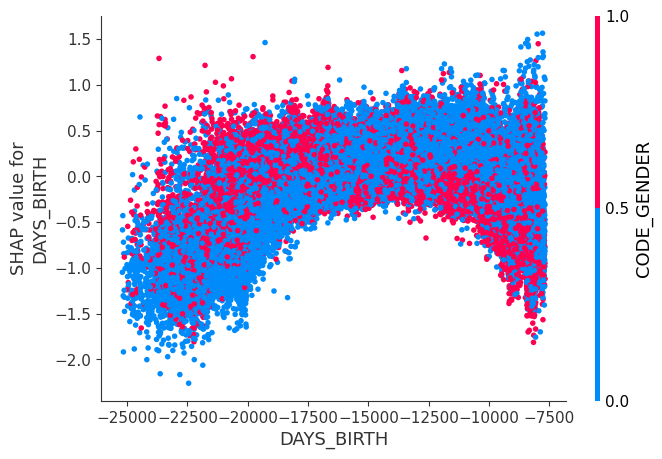

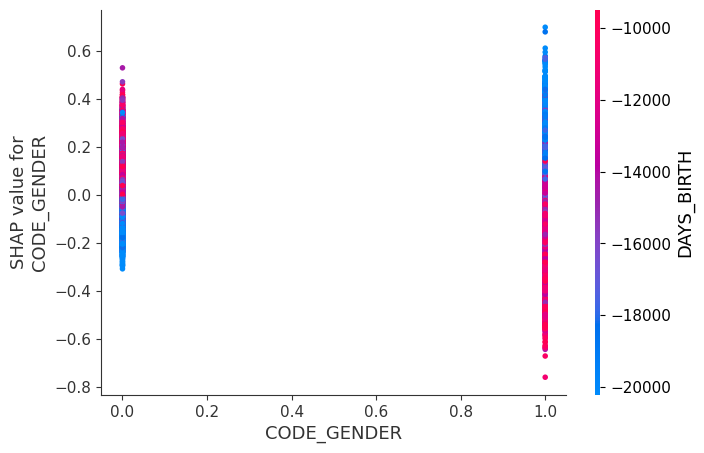

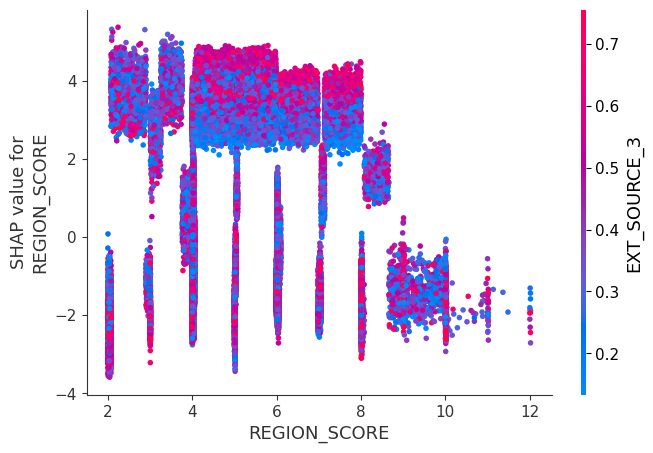

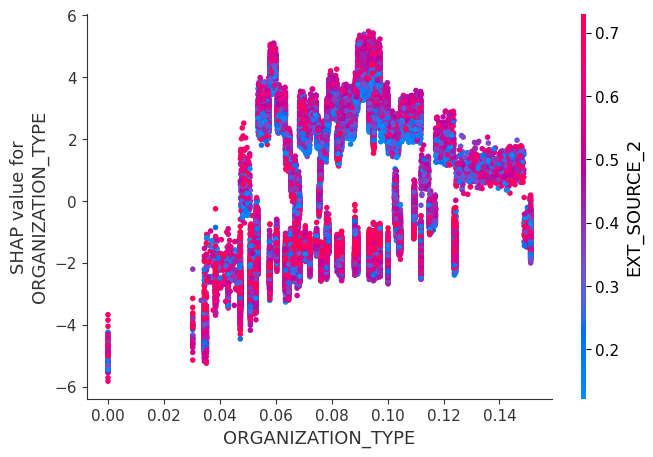

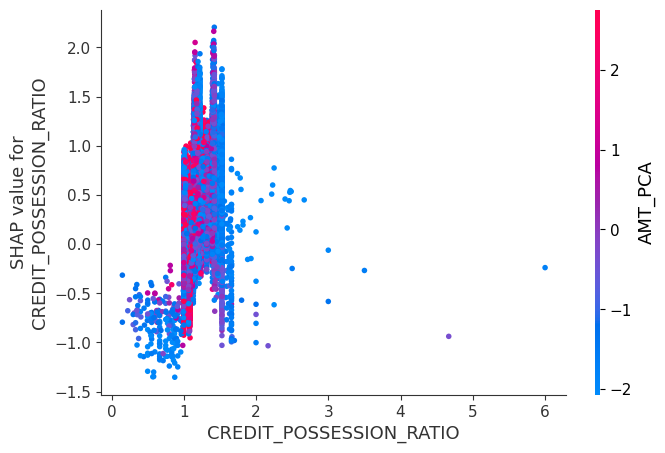

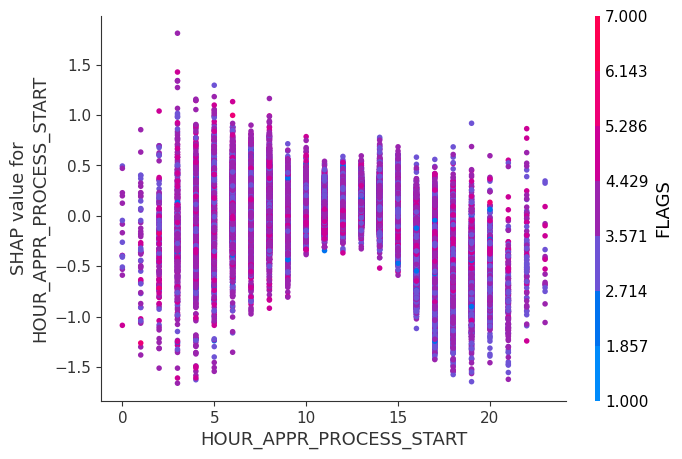

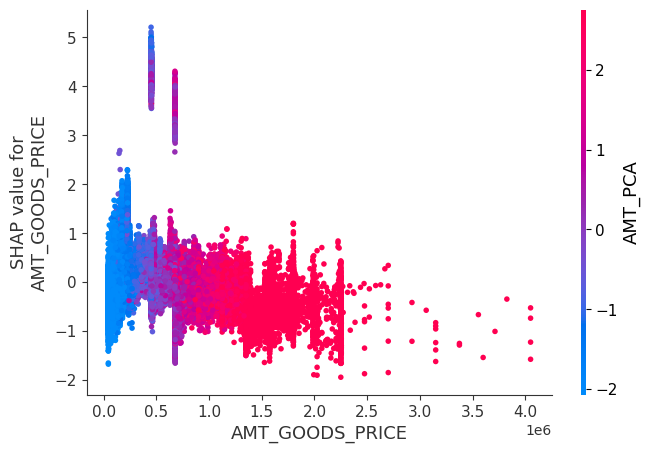

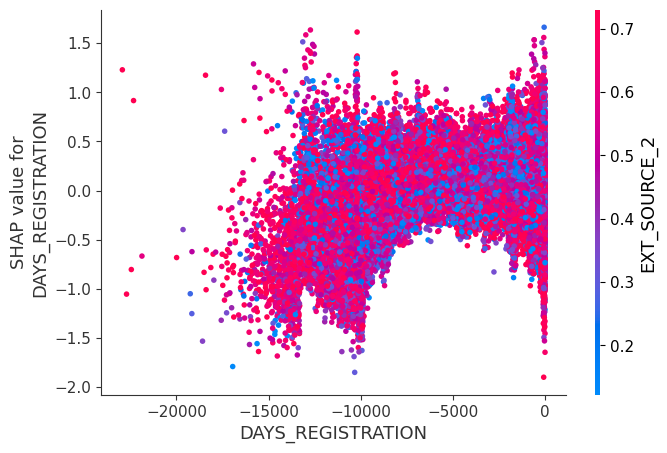

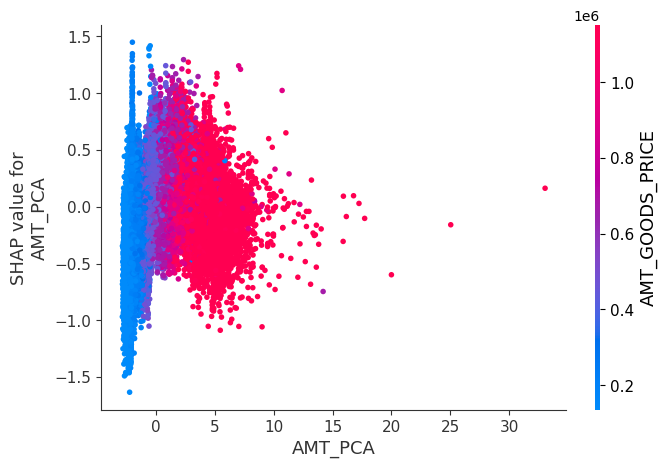

In [46]:
for name in X_train.columns:
    shap.dependence_plot(name, shap_values.values, X_train, display_features=X_train)

# Explication Locale